In [10]:
# Import the required libraries
import os
import torch
import numpy as np
import transformers
from transformers import AutoModelForSequenceClassification, GlueDataTrainingArguments, AutoTokenizer
import torchmetrics
import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

from apx import ApproxEmbed, ApxSVD
from glue_score import GLUE_TASKS, make_model, Glue, plot

In [12]:
transformers.utils.logging.set_verbosity_error()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

epochs=5
lr=5e-5

saved_dict = torch.load('results/compression/8_8.pth')

runs=["Original","Compressed Adaptive","Compressed Fixed", "Compressed SVD"]

sst2 Original


Found cached dataset glue (C:/Users/Sam/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Found cached dataset glue (C:/Users/Sam/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Epoch: 5: 100%|██████████| 2105/2105 [00:43<00:00, 48.57it/s, loss: 0.0957]


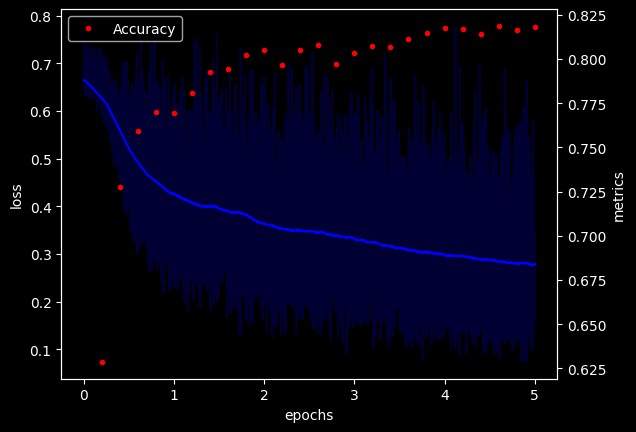

sst2 Compressed Adaptive


Found cached dataset glue (C:/Users/Sam/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Found cached dataset glue (C:/Users/Sam/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Epoch: 5: 100%|██████████| 2105/2105 [00:43<00:00, 48.05it/s, loss: 0.0963]


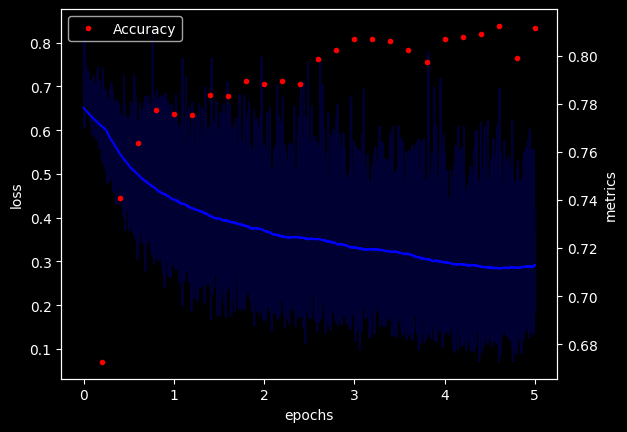

sst2 Compressed Fixed


Found cached dataset glue (C:/Users/Sam/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Found cached dataset glue (C:/Users/Sam/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Epoch: 5: 100%|██████████| 2105/2105 [00:43<00:00, 48.30it/s, loss: 0.0972]


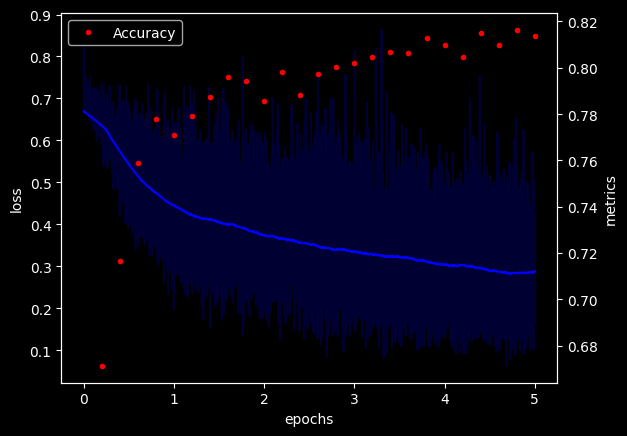

sst2 Compressed SVD


Found cached dataset glue (C:/Users/Sam/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Found cached dataset glue (C:/Users/Sam/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Epoch: 5: 100%|██████████| 2105/2105 [00:43<00:00, 48.14it/s, loss: 0.0958]


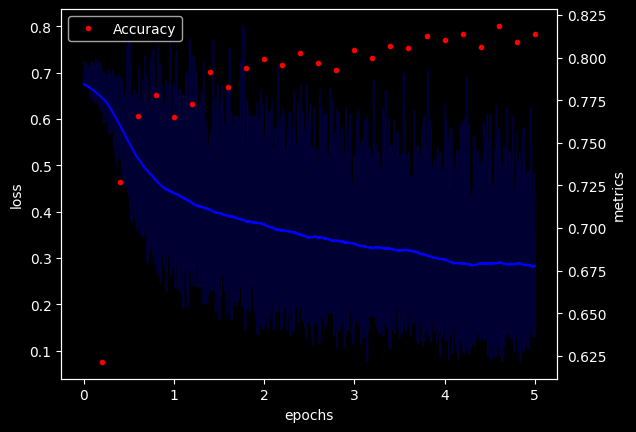

In [13]:
RESULTS={}
for task in list(GLUE_TASKS.keys())[1:2]:
    results={}
    for run in runs:
        print(task,run)
        args=GLUE_TASKS[task]
        model=make_model('prajjwal1/bert-tiny',args)
        if run=="compressed adaptive":
            apx = ApproxEmbed(levels=saved_dict['level'],
                feature_dim=saved_dict['channel'],
                num_words=model.bert.embeddings.word_embeddings.weight.shape[0],
                output_dims=model.bert.embeddings.word_embeddings.weight.shape[1],
                )
            apx.load_state_dict(saved_dict['apx'])
            model.bert.embeddings.word_embeddings = apx.to('cuda')
        elif run=="compressed fixed":
            apx = ApproxEmbed(levels=saved_dict['level'],
                feature_dim=saved_dict['channel'],
                num_words=model.bert.embeddings.word_embeddings.weight.shape[0],
                output_dims=model.bert.embeddings.word_embeddings.weight.shape[1],
                )
            apx.load_state_dict(saved_dict['apx'])
            apx.fix_indices()
            model.bert.embeddings.word_embeddings = apx.to('cuda')
        elif run=="compressed SVD":
            apxSVD = ApxSVD(model.bert.embeddings.word_embeddings.weight, 5)
            model.bert.embeddings.word_embeddings = apxSVD.to('cuda')
        H,V = Glue(model, tokenizer, task, args, epochs=epochs, steps_validate=0.2)
        plot(H,V)
        results[run]={'history':H,'validation':V}
    RESULTS[task]=results

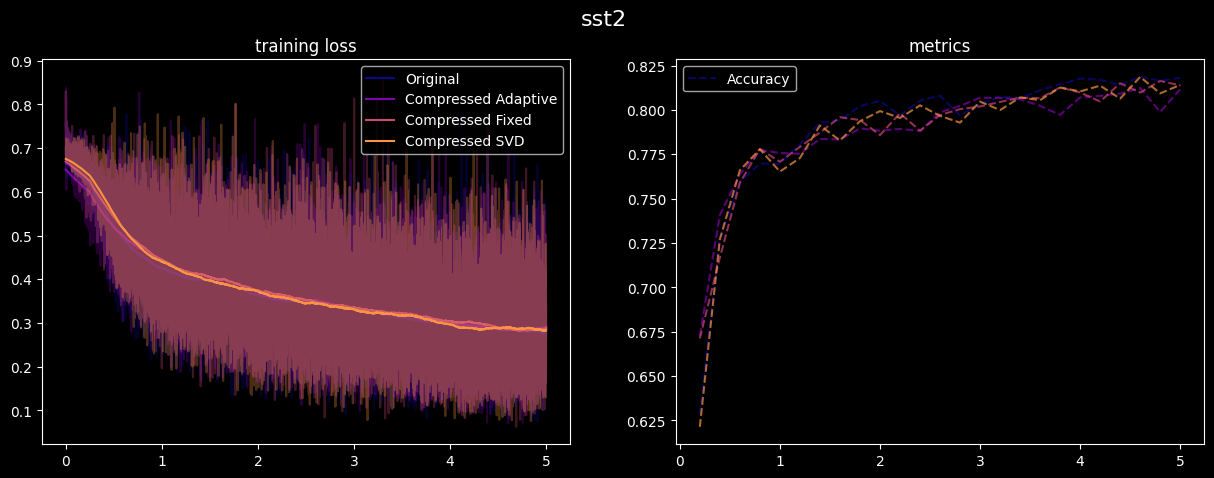

In [14]:
from glue_score import plot_results_retrain
plot_results_retrain(RESULTS)

In [ ]:
save_path='results/'
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

torch.save(RESULTS, save_path+'glue_results_retrain.pth')

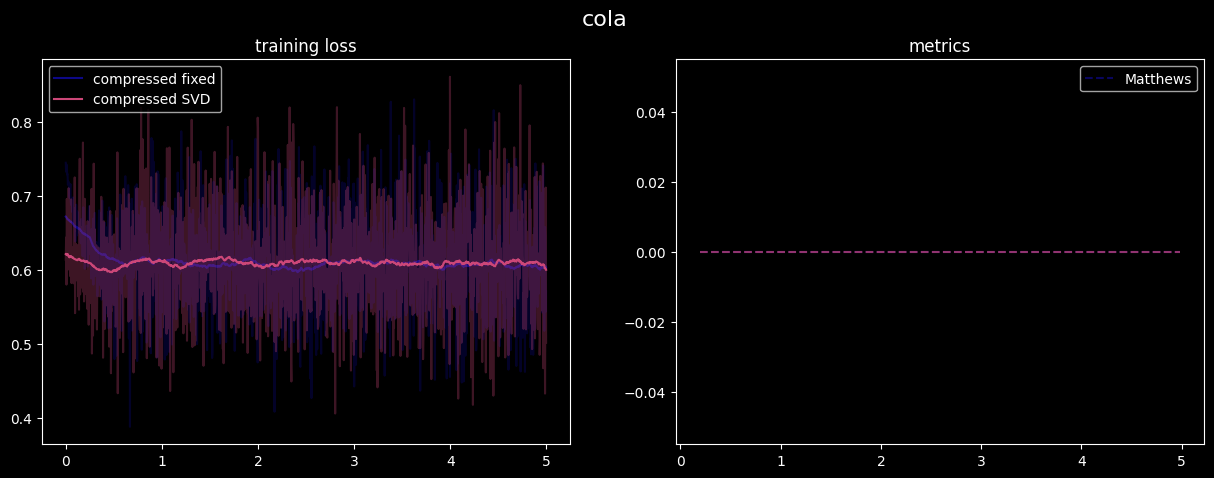

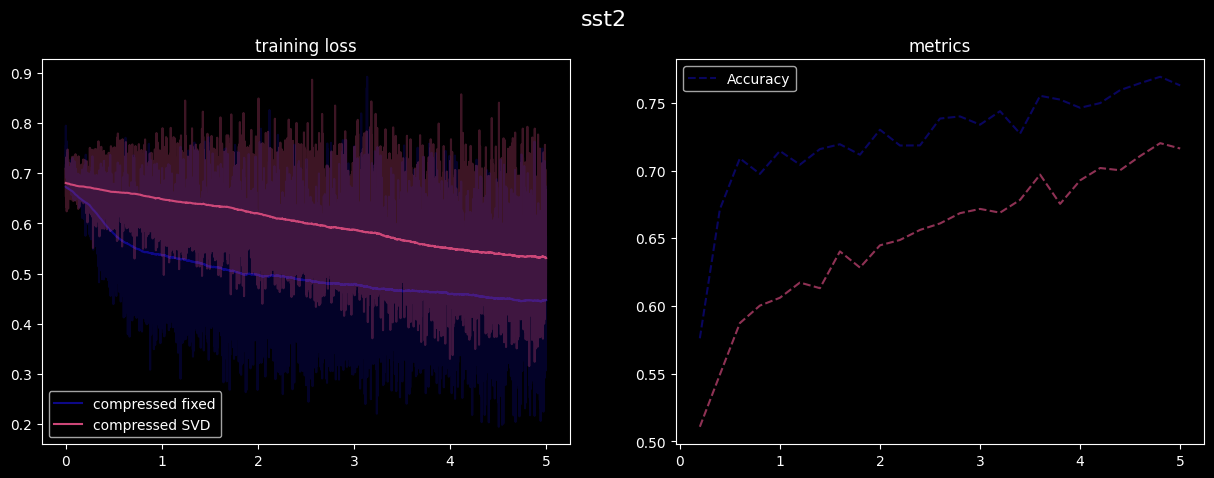

In [ ]:

import torch

run_dict=torch.load('results/glue_results_retrain.pth')
plot_results_retrain(RESULTS)